In [1]:
# basics
import numpy as np
import pandas as pd
import datetime
import re
import os,glob
import pickle
import textwrap

# statistics
import statsmodels.api as sm
import statsmodels.formula.api as smf


# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15,12]

# own data wrappers
from imp import reload
import measureclass as mc; reload(mc);
import coronadataclass as cdc; reload(cdc);
import crossvalidationclass as cvc; reload(cvc);

np.seterr(divide = 'ignore');

default_params   = {'ExternalObservableFile': 'COVID19_data_PAPER_VERSION.csv',
                    'datasourceinfo':{'DatafileName':'COVID19_non-pharmaceutical-interventions_PAPER_VERSION.csv'},
                    'resolve_US_states': True,
                    'FinalDateFile': 'CCCSL_enddates.csv',
                    'FinalDateFileDateFormat': '%Y-%m-%d',
                    'FinalDateExtendWithShiftdays':True}


In [34]:
crossval = cvc.CrossValidation()
crossval_cn = cvc.CrossValidation(datasource = 'CORONANET')
crossval_who = cvc.CrossValidation(datasource = 'WHOPHSM')

In [29]:
# CCCSL

mainresults = pd.read_csv('data/comparison_of_rankings_revision - Main_results.csv')

score_results = pd.read_csv('data/comparison_of_rankings_revision - L2 Scores.csv', header = 0, skiprows=1)

mainresults = mainresults.merge(score_results,left_on = ['Indexname'], right_on = ['Indexname'])

mainresults.fillna(0, inplace = True)

mainresults.head()

Indexname  \
0                         ActivateCaseNotification   
1             ActivateOrEstablishEmergencyResponse   
2  ActivelyCommunicateWithHealthcareProfessionals1   
3                 ActivelyCommunicateWithManagers1   
4              AdaptProceduresForPatientManagement   

                                            L1 theme  \
0  Case identification, contact tracing and relat...   
1                                Resource allocation   
2                                 Risk communication   
3                                 Risk communication   
4              Healthcare and public health capacity   

                                         L2 category  \
0                         Activate case notification   
1           Activate or establish emergency response   
2  Actively communicate with healthcare professio...   
3                 Actively communicate with managers   
4            Adapt procedures for patient management   

   Territories with Implementation  Delta_RF  95%CI_Delta_RF  Delta_CC  \
0                             20.0  0.002962        0.000916   0.00000   
1                             71.0  0.003723        0.000895  -0.12577   
2                             30.0  0.003126        0.001436   0.00000   
3                             42.0  0.004493        0.001553  -0.15034   
4                             39.0  0.000160        0.000905  -0.16264   

   95%CI_Delta_CC  Rank_RNN  Delta_RNN  ...      CC.2   LASSO.2      RF.2  \
0           0.000      44.0   0.012141  ...  0.000000  0.000000  0.148686   
1           0.021       8.0  -0.011525  ...  0.622182  0.000000  0.000000   
2           0.000      18.0  -0.004960  ...  0.293739  0.342954  0.119320   
3           0.020      29.0  -0.001530  ...  0.496243  0.857385  0.189490   
4           0.027      31.0  -0.000193  ...  0.500537  0.000000  0.000000   

   Transformer.2    Mean.2      CC.3   LASSO.3      RF.3  Transformer.3  \
0       0.000000  0.037172  0.000000  0.000000  0.272458       0.000000   
1       0.193861  0.204011  0.000000  0.000000  0.160908       0.695039   
2       0.061876  0.204472  0.000000  0.000000  0.000000       0.048342   
3       0.000000  0.385780  0.522117  1.000000  0.134255       0.177860   
4       0.133697  0.158559  0.000000  0.307018  0.000000       0.196040   

     Mean.3  
0  0.068115  
1  0.213987  
2  0.012086  
3  0.458558  
4  0.125764  

[5 rows x 42 columns]

In [30]:
mainresults['CC_low']   = mainresults['Delta_CC']  - mainresults['95%CI_Delta_CC']
mainresults['RF_low']   = mainresults['Delta_RF']  - mainresults['95%CI_Delta_RF']
mainresults['TF_low']   = mainresults['Delta_Transformer'] - mainresults['95%CI_Delta_Transformer']

mainresults['CC_high']  = mainresults['Delta_CC']  + mainresults['95%CI_Delta_CC']
mainresults['RF_high']  = mainresults['Delta_RF']  + mainresults['95%CI_Delta_RF']
mainresults['TF_high']  = mainresults['Delta_Transformer'] + mainresults['95%CI_Delta_Transformer']

mainresults['SCORE_low']  = mainresults['Mean']
mainresults['SCORE_high'] = mainresults['Mean']

mainresults.rename({'LASSO_median':'LASSO_DeltaR','LASSO_low95':'LASSO_low','LASSO_high95':'LASSO_high','Delta_CC':'CC_DeltaR','Delta_RF':'RF_DeltaR','Delta_Transformer':'TF_DeltaR','Mean':'SCORE_DeltaR'}, axis = 'columns', inplace = True)
mainresults.head()

Indexname  \
0                         ActivateCaseNotification   
1             ActivateOrEstablishEmergencyResponse   
2  ActivelyCommunicateWithHealthcareProfessionals1   
3                 ActivelyCommunicateWithManagers1   
4              AdaptProceduresForPatientManagement   

                                            L1 theme  \
0  Case identification, contact tracing and relat...   
1                                Resource allocation   
2                                 Risk communication   
3                                 Risk communication   
4              Healthcare and public health capacity   

                                         L2 category  \
0                         Activate case notification   
1           Activate or establish emergency response   
2  Actively communicate with healthcare professio...   
3                 Actively communicate with managers   
4            Adapt procedures for patient management   

   Territories with Implementation  RF_DeltaR  95%CI_Delta_RF  CC_DeltaR  \
0                             20.0   0.002962        0.000916    0.00000   
1                             71.0   0.003723        0.000895   -0.12577   
2                             30.0   0.003126        0.001436    0.00000   
3                             42.0   0.004493        0.001553   -0.15034   
4                             39.0   0.000160        0.000905   -0.16264   

   95%CI_Delta_CC  Rank_RNN  Delta_RNN  ...  Transformer.3    Mean.3   CC_low  \
0           0.000      44.0   0.012141  ...       0.000000  0.068115  0.00000   
1           0.021       8.0  -0.011525  ...       0.695039  0.213987 -0.14677   
2           0.000      18.0  -0.004960  ...       0.048342  0.012086  0.00000   
3           0.020      29.0  -0.001530  ...       0.177860  0.458558 -0.17034   
4           0.027      31.0  -0.000193  ...       0.196040  0.125764 -0.18964   

     RF_low    TF_low  CC_high   RF_high   TF_high  SCORE_low  SCORE_high  
0  0.002046  0.004906  0.00000  0.003878  0.006759   0.052138    0.052138  
1  0.002828 -0.041158 -0.10477  0.004618 -0.040053   0.295562    0.295562  
2  0.001690 -0.001633  0.00000  0.004562 -0.000615   0.107053    0.107053  
3  0.002940  0.004889 -0.13034  0.006046  0.005853   0.403614    0.403614  
4 -0.000745 -0.012034 -0.13564  0.001065 -0.010959   0.127019    0.127019  

[5 rows x 50 columns]

In [31]:
L1colors = crossval.L1colors

def PlotMeasureListSorted(measure_effects = None, plot_keys = [], filename = 'measurelist_sorted.pdf', drop_zeros = False, figsize = (15,30), labelsize = 40, blacklines = [0], graylines = [-30,-20,-10,10], border = 2, title = '', textbreak = 40, include_countries = False, rescale = False, entryheight = None, sort_ascending = True, observable = r'$\Delta R_t$', observable_text_pos = [0,2]):
    # get plotting area
    minplot      = np.min(blacklines + graylines)
    maxplot      = np.max(blacklines + graylines)

    # function to plot one row in DF
    def PlotRow(ax, ypos = 1, values = None, color = '#ffffff', boxalpha = .4, textbreak = 40):
        ax.plot(values[plot_keys[0]],[ypos], c = color, marker = 'D')
        ax.plot([values[plot_keys[1]],values[plot_keys[2]]],[ypos,ypos], c = color, lw = 2)
        background = plt.Rectangle([1e-2 * (minplot - border - 2 * labelsize), ypos - .4], 1e-2*(2*labelsize + maxplot + border - minplot), .9, fill = True, fc = color, alpha = boxalpha, zorder = 1)
        ax.add_patch(background)
        ax.annotate(textwrap.shorten(values['L1 theme'],    width = textbreak), [1e-2*(minplot - 2 * labelsize), ypos - .1], zorder = 5)
        ax.annotate(textwrap.shorten(values['L2 category'], width = textbreak), [1e-2*(minplot - 1 * labelsize), ypos - .1], zorder = 5)
    
    me_local = measure_effects[(measure_effects[plot_keys[0]]!=0) | (measure_effects[plot_keys[1]]!=0) | (measure_effects[plot_keys[2]]!=0)]
    me_local.sort_values(by = plot_keys, ascending = sort_ascending, inplace = True)
                 
    # actual plotting including vertical lines
    if not entryheight is None:
        figsize = (figsize[0],(len(me_local) + 4.5) * entryheight)
    fig, ax = plt.subplots(1,1,figsize = figsize)

    for j,(index,values) in enumerate(me_local.iterrows()):
        PlotRow(ax, ypos = -j,values = values, color = L1colors[values['L1 theme']], textbreak = textbreak)
    for x in blacklines:
        ax.plot([1e-2 * x,1e-2 * x],[0.7,-j-0.5], lw = 2, c = 'black',zorder = -2)
        ax.annotate('{:.2f}'.format(x * 1e-2),[1e-2*x,0.9],fontsize = 12, c = 'gray', ha = 'center')
    for x in graylines:
        ax.plot([1e-2 * x,1e-2 * x],[0.6,-j-0.4], lw = 1, c = 'gray',zorder = -2)
        ax.annotate('{:.2f}'.format(x * 1e-2),[1e-2*x,0.9],fontsize = 12, c = 'gray', ha = 'center')

    # format output
    if title != '':
        ax.annotate(title,[1e-2 * (-2*labelsize + minplot),2], fontsize = 12, weight = 'bold')
    ax.annotate('L1 Theme',[1e-2 * (-2*labelsize + minplot), 1], weight = 'bold', fontsize = 12)
    ax.annotate('L2 Category', [1e-2 * (-labelsize + minplot), 1], weight = 'bold', fontsize = 12)
    ax.annotate(observable,observable_text_pos, fontsize = 12, weight = 'bold')
    ax.set_xlim([1e-2 * (-2 * labelsize - 2*border + minplot), 1e-2 * (maxplot+border)])
    ax.set_ylim([-j-2,2.5])
    ax.axis('off')

    fig.tight_layout()
    fig.savefig(filename, bbox_inches = 'tight')



/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


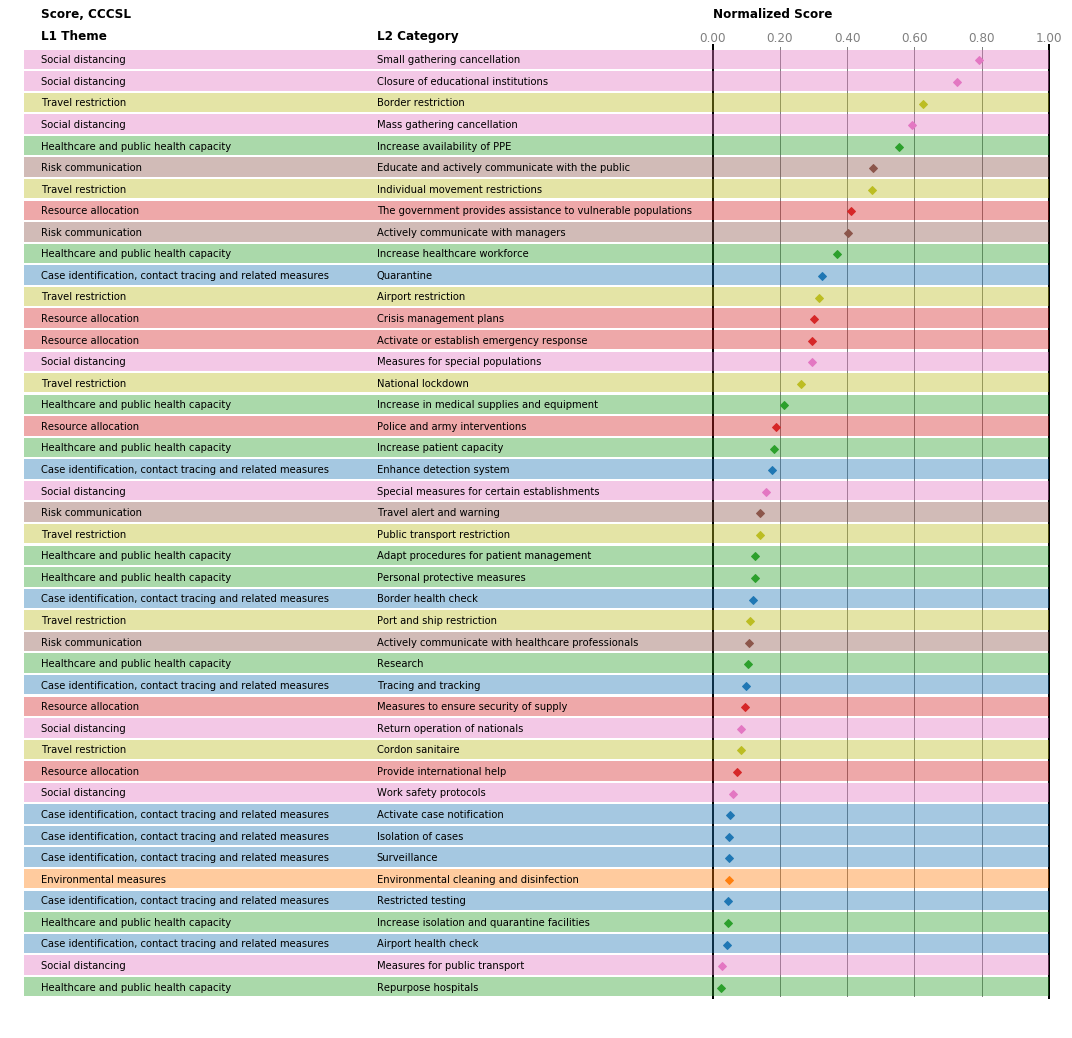

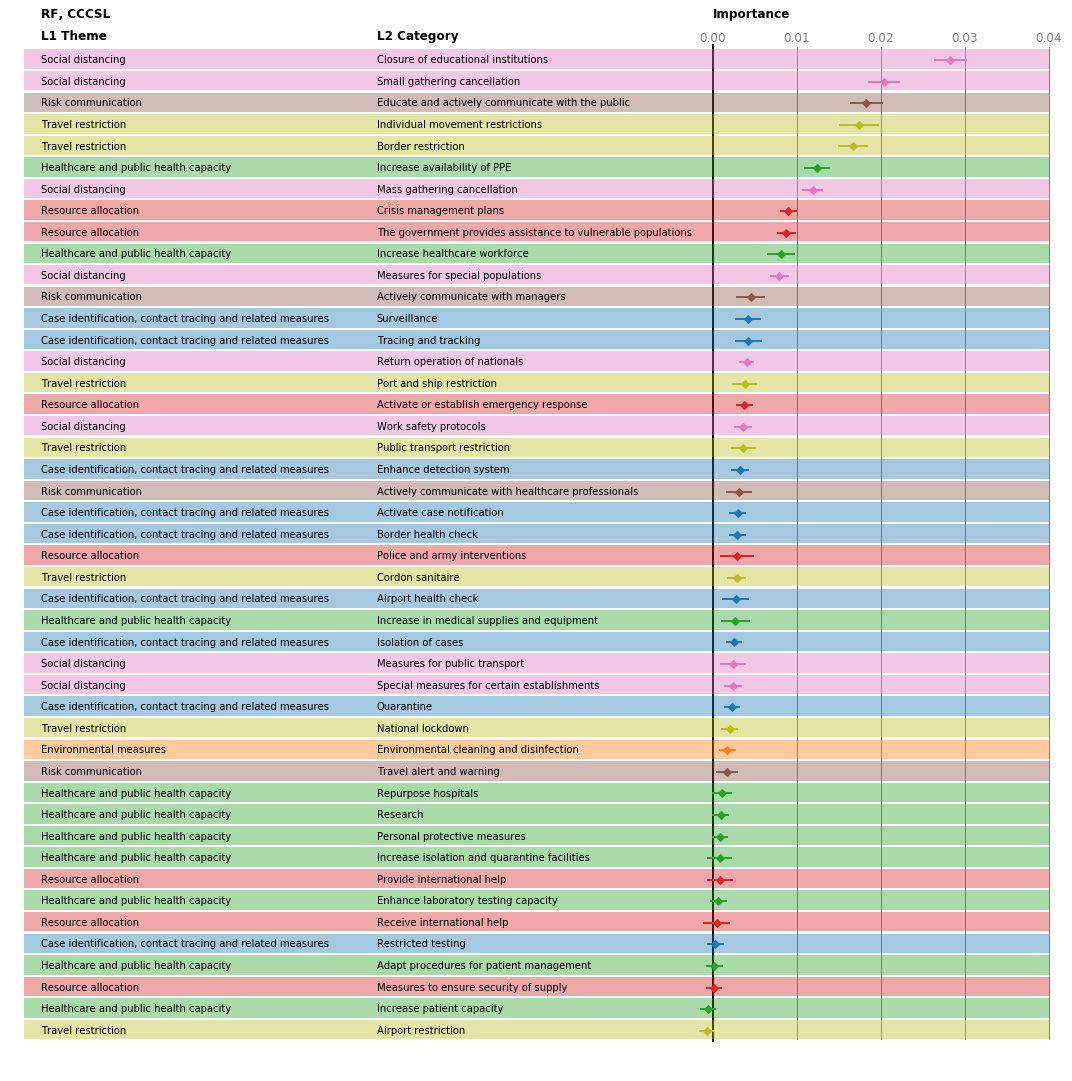

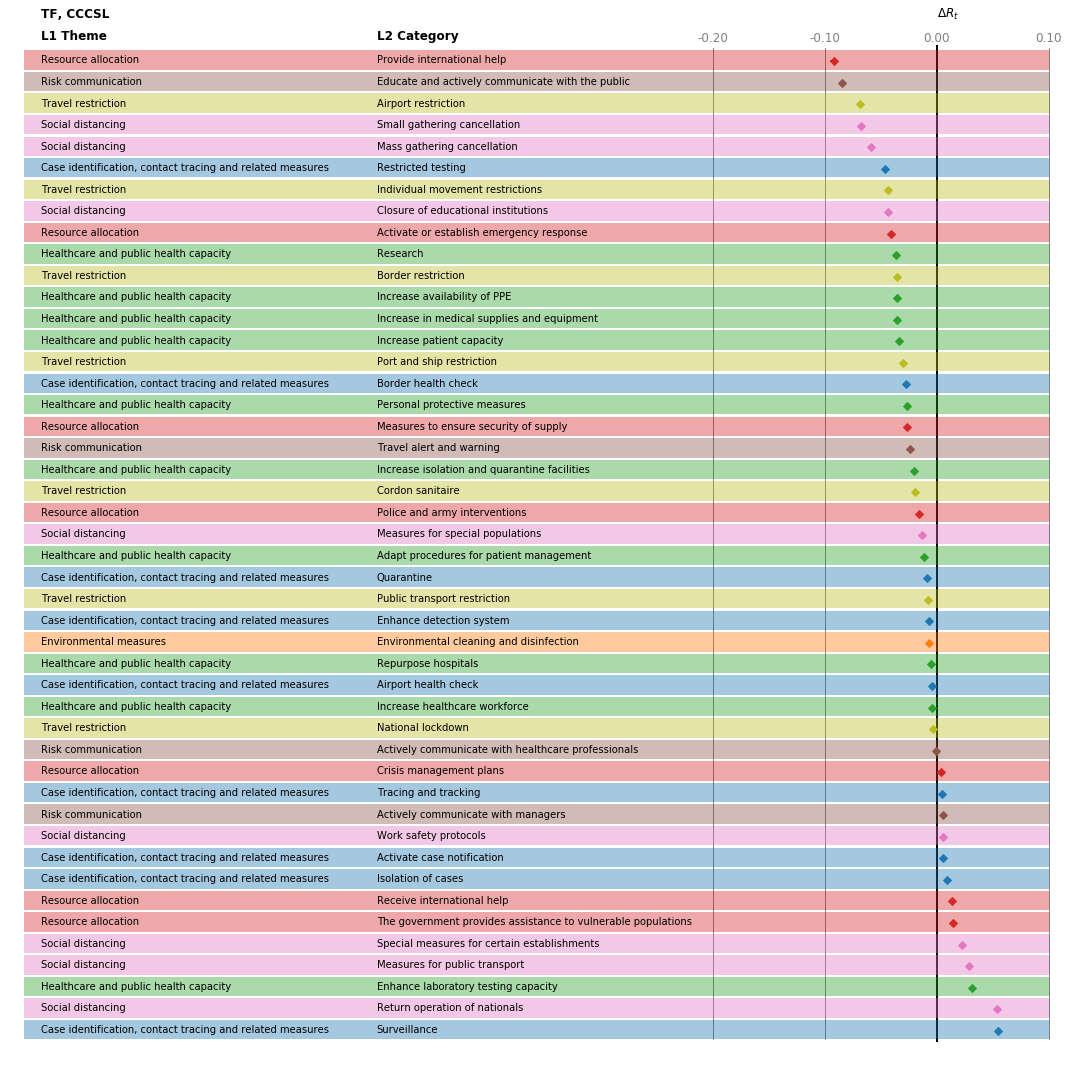

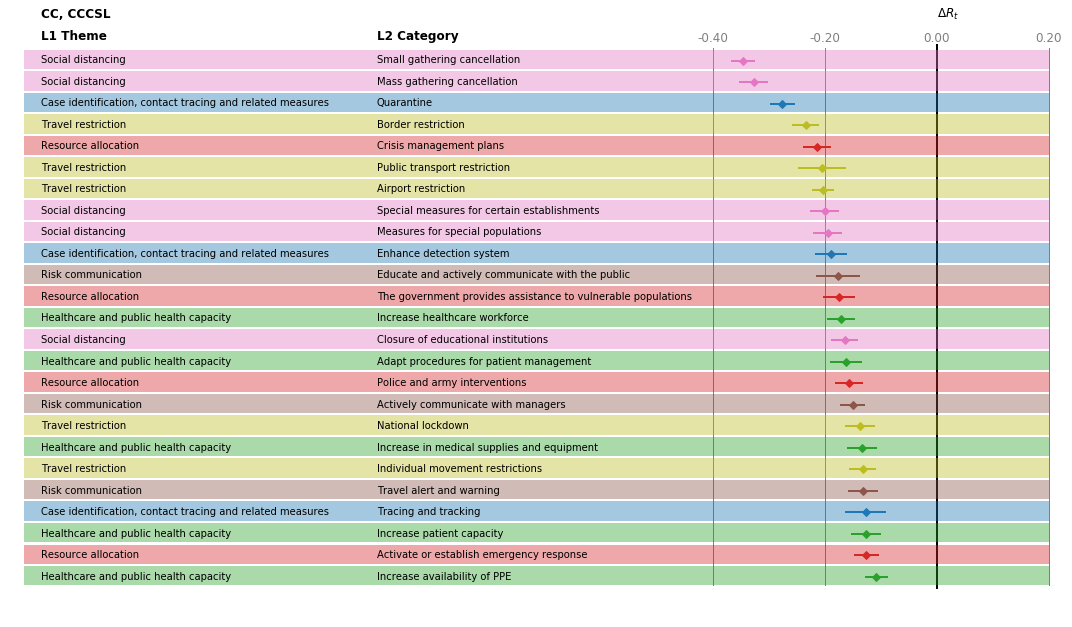

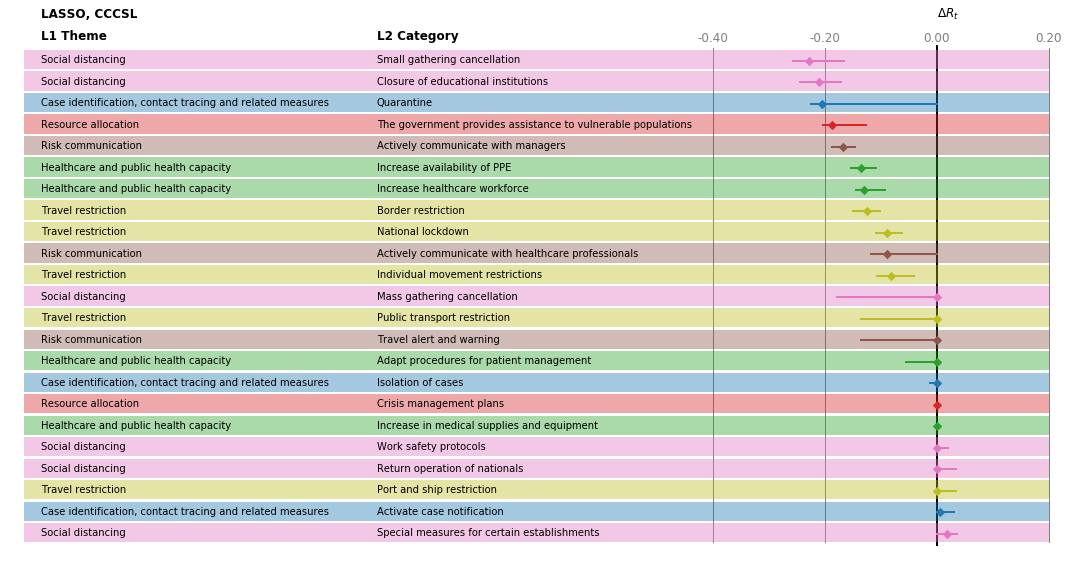

In [32]:
drop_zeros = True
measure_effects = {}
sort_order = {'RF':False,'CC':True,'TF':True,'LASSO':True,'SCORE':False}
textbreak = 60
plot_keys = {}
for method in sort_order.keys():
    plot_keys[method] = ['{}_DeltaR'.format(method),'{}_low'.format(method),'{}_high'.format(method)]

PlotMeasureListSorted(measure_effects = mainresults, plot_keys = plot_keys['SCORE'], sort_ascending = sort_order['SCORE'], entryheight=.3, title = 'Score, CCCSL', filename = 'measurelist_200906_CCCSL_SCORES.pdf', textbreak = textbreak, graylines = [20,40,60,80], blacklines = [0,100], labelsize = 100, border = 5, observable = 'Normalized Score')
PlotMeasureListSorted(measure_effects = mainresults, plot_keys = plot_keys['RF'],    sort_ascending = sort_order['RF'],    entryheight=.3, title = 'RF, CCCSL',    filename = 'measurelist_200906_CCCSL_RF.pdf',     textbreak = textbreak, graylines = [1,2,3,4],    labelsize = 4,  border = .2, observable = 'Importance')
PlotMeasureListSorted(measure_effects = mainresults, plot_keys = plot_keys['TF'],    sort_ascending = sort_order['TF'],    entryheight=.3, title = 'TF, CCCSL',    filename = 'measurelist_200906_CCCSL_TF.pdf',     textbreak = textbreak, graylines = [-10,-20,10], labelsize = 30, border = 1.5)
PlotMeasureListSorted(measure_effects = mainresults, plot_keys = plot_keys['CC'],    sort_ascending = sort_order['CC'],    entryheight=.3, title = 'CC, CCCSL',    filename = 'measurelist_200906_CCCSL_CC.pdf',     textbreak = textbreak, graylines = [-40,-20,20], labelsize = 60, border = 3)
PlotMeasureListSorted(measure_effects = mainresults, plot_keys = plot_keys['LASSO'], sort_ascending = sort_order['LASSO'], entryheight=.3, title = 'LASSO, CCCSL', filename = 'measurelist_200906_CCCSL_LASSO.pdf',  textbreak = textbreak, graylines = [-40,-20,20], labelsize = 60, border = 3)



In [33]:
# CORONANET

mainresults_cn = pd.read_csv('data/comparison_of_rankings_revision - Main_results_CORONANET.csv')

score_results_cn = pd.read_csv('data/comparison_of_rankings_revision - L2 Scores_CORONANET.csv', header = 0)

mainresults_cn = mainresults_cn.merge(score_results_cn,left_on = ['Indexname'], right_on = ['Indexname'])

mainresults_cn.fillna(0, inplace = True)

mainresults_cn.head()

Indexname  \
0     AllEssentialGovernmentServicesRegulated   
1  AllNonEssentialGovernmentServicesRegulated   
2         AllOrUnspecifiedEssentialBusinesses   
3      AllOrUnspecifiedNonEssentialBusinesses   
4                   AllPublicSpacesEverywhere   

                                            L1 theme  \
0  Restriction and Regulation of Government Services   
1  Restriction and Regulation of Government Services   
2           Restriction and Regulation of Businesses   
3           Restriction and Regulation of Businesses   
4                                  Social Distancing   

                                       L2 category  \
0      All essential government services regulated   
1  All non-essential government services regulated   
2          All or unspecified essential businesses   
3      All or unspecified non-essential businesses   
4                   All public spaces / everywhere   

   Territories with Implementation  Delta_RF  95%CI_Delta_RF  Delta_CC  \
0                                8  0.002771        0.000762       0.0   
1                               15  0.000916        0.000777       0.0   
2                               21  0.001683        0.000760       0.0   
3                               47  0.001436        0.000943       0.0   
4                               45  0.000992        0.000980       0.0   

   95%CI_Delta_CC  Rank_RNN  Delta_RNN  ...  LASSO_mean  LASSO_std   CC  \
0             0.0        10  -0.030576  ...    0.000000   0.000000  0.0   
1             0.0       104   0.053070  ...    0.000000   0.000000  0.0   
2             0.0        94   0.033100  ...    0.000197   0.002796  0.0   
3             0.0        45  -0.003273  ...    0.054628   0.005907  0.0   
4             0.0        25  -0.017296  ...    0.000000   0.000000  0.0   

   LASSO        RF  Transformer      Mean  Prevalence All Countries  \
0    0.0  0.256198     0.000000  0.064050                  0.014811   
1    0.0  0.083004     0.011201  0.023551                  0.029526   
2    0.0  0.155947     0.000000  0.038987                  0.047280   
3    0.0  0.107079     0.000000  0.026770                  0.112598   
4    0.0  0.071146     0.114163  0.046327                  0.106427   

   Prevalence Implementing Countries  Fraction of Implementating Countries  
0                           0.501608                              0.026178  
1                           0.676087                              0.036649  
2                           0.408867                              0.099476  
3                           0.503823                              0.188482  
4                           0.469234                              0.188482  

[5 rows x 27 columns]

In [35]:
mainresults_cn['CC_low']   = mainresults_cn['Delta_CC']  - mainresults_cn['95%CI_Delta_CC']
mainresults_cn['RF_low']   = mainresults_cn['Delta_RF']  - mainresults_cn['95%CI_Delta_RF']
mainresults_cn['TF_low']   = mainresults_cn['Delta_Transformer'] - mainresults_cn['95%CI_Delta_Transformer']

mainresults_cn['CC_high']  = mainresults_cn['Delta_CC']  + mainresults_cn['95%CI_Delta_CC']
mainresults_cn['RF_high']  = mainresults_cn['Delta_RF']  + mainresults_cn['95%CI_Delta_RF']
mainresults_cn['TF_high']  = mainresults_cn['Delta_Transformer'] + mainresults_cn['95%CI_Delta_Transformer']

mainresults_cn['SCORE_low']  = mainresults_cn['Mean']
mainresults_cn['SCORE_high'] = mainresults_cn['Mean']

mainresults_cn.rename({'LASSO_median':'LASSO_DeltaR','LASSO_low95':'LASSO_low','LASSO_high95':'LASSO_high','Delta_CC':'CC_DeltaR','Delta_RF':'RF_DeltaR','Delta_Transformer':'TF_DeltaR','Mean':'SCORE_DeltaR'}, axis = 'columns', inplace = True)
mainresults_cn.head()

Indexname  \
0     AllEssentialGovernmentServicesRegulated   
1  AllNonEssentialGovernmentServicesRegulated   
2         AllOrUnspecifiedEssentialBusinesses   
3      AllOrUnspecifiedNonEssentialBusinesses   
4                   AllPublicSpacesEverywhere   

                                            L1 theme  \
0  Restriction and Regulation of Government Services   
1  Restriction and Regulation of Government Services   
2           Restriction and Regulation of Businesses   
3           Restriction and Regulation of Businesses   
4                                  Social Distancing   

                                       L2 category  \
0      All essential government services regulated   
1  All non-essential government services regulated   
2          All or unspecified essential businesses   
3      All or unspecified non-essential businesses   
4                   All public spaces / everywhere   

   Territories with Implementation  RF_DeltaR  95%CI_Delta_RF  CC_DeltaR  \
0                                8   0.002771        0.000762        0.0   
1                               15   0.000916        0.000777        0.0   
2                               21   0.001683        0.000760        0.0   
3                               47   0.001436        0.000943        0.0   
4                               45   0.000992        0.000980        0.0   

   95%CI_Delta_CC  Rank_RNN  Delta_RNN  ...  \
0             0.0        10  -0.030576  ...   
1             0.0       104   0.053070  ...   
2             0.0        94   0.033100  ...   
3             0.0        45  -0.003273  ...   
4             0.0        25  -0.017296  ...   

   Prevalence Implementing Countries  Fraction of Implementating Countries  \
0                           0.501608                              0.026178   
1                           0.676087                              0.036649   
2                           0.408867                              0.099476   
3                           0.503823                              0.188482   
4                           0.469234                              0.188482   

   CC_low    RF_low    TF_low  CC_high   RF_high   TF_high  SCORE_low  \
0     0.0  0.002009  0.020108      0.0  0.003533  0.033696   0.064050   
1     0.0  0.000139 -0.006462      0.0  0.001693 -0.000643   0.023551   
2     0.0  0.000923  0.030581      0.0  0.002443  0.035227   0.038987   
3     0.0  0.000493 -0.000497      0.0  0.002379  0.001923   0.026770   
4     0.0  0.000012 -0.017791      0.0  0.001972 -0.015141   0.046327   

   SCORE_high  
0    0.064050  
1    0.023551  
2    0.038987  
3    0.026770  
4    0.046327  

[5 rows x 35 columns]

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

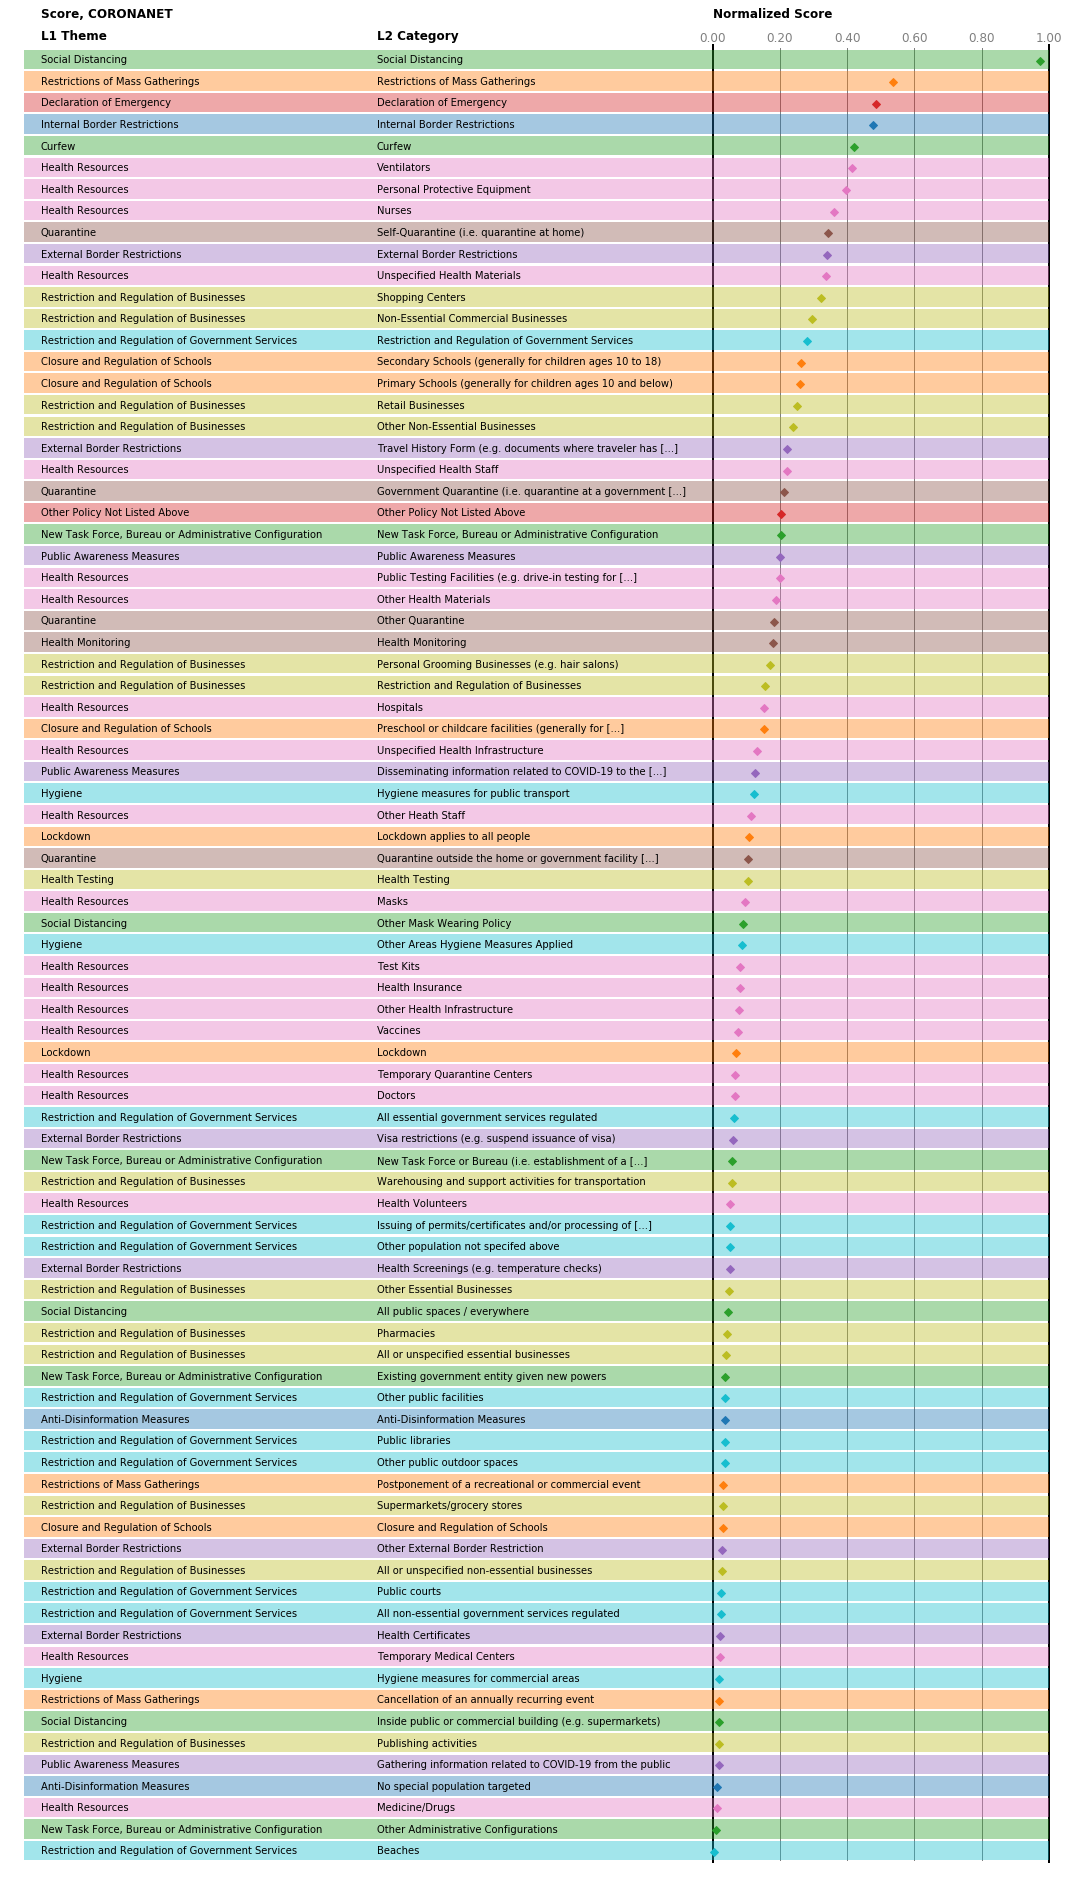

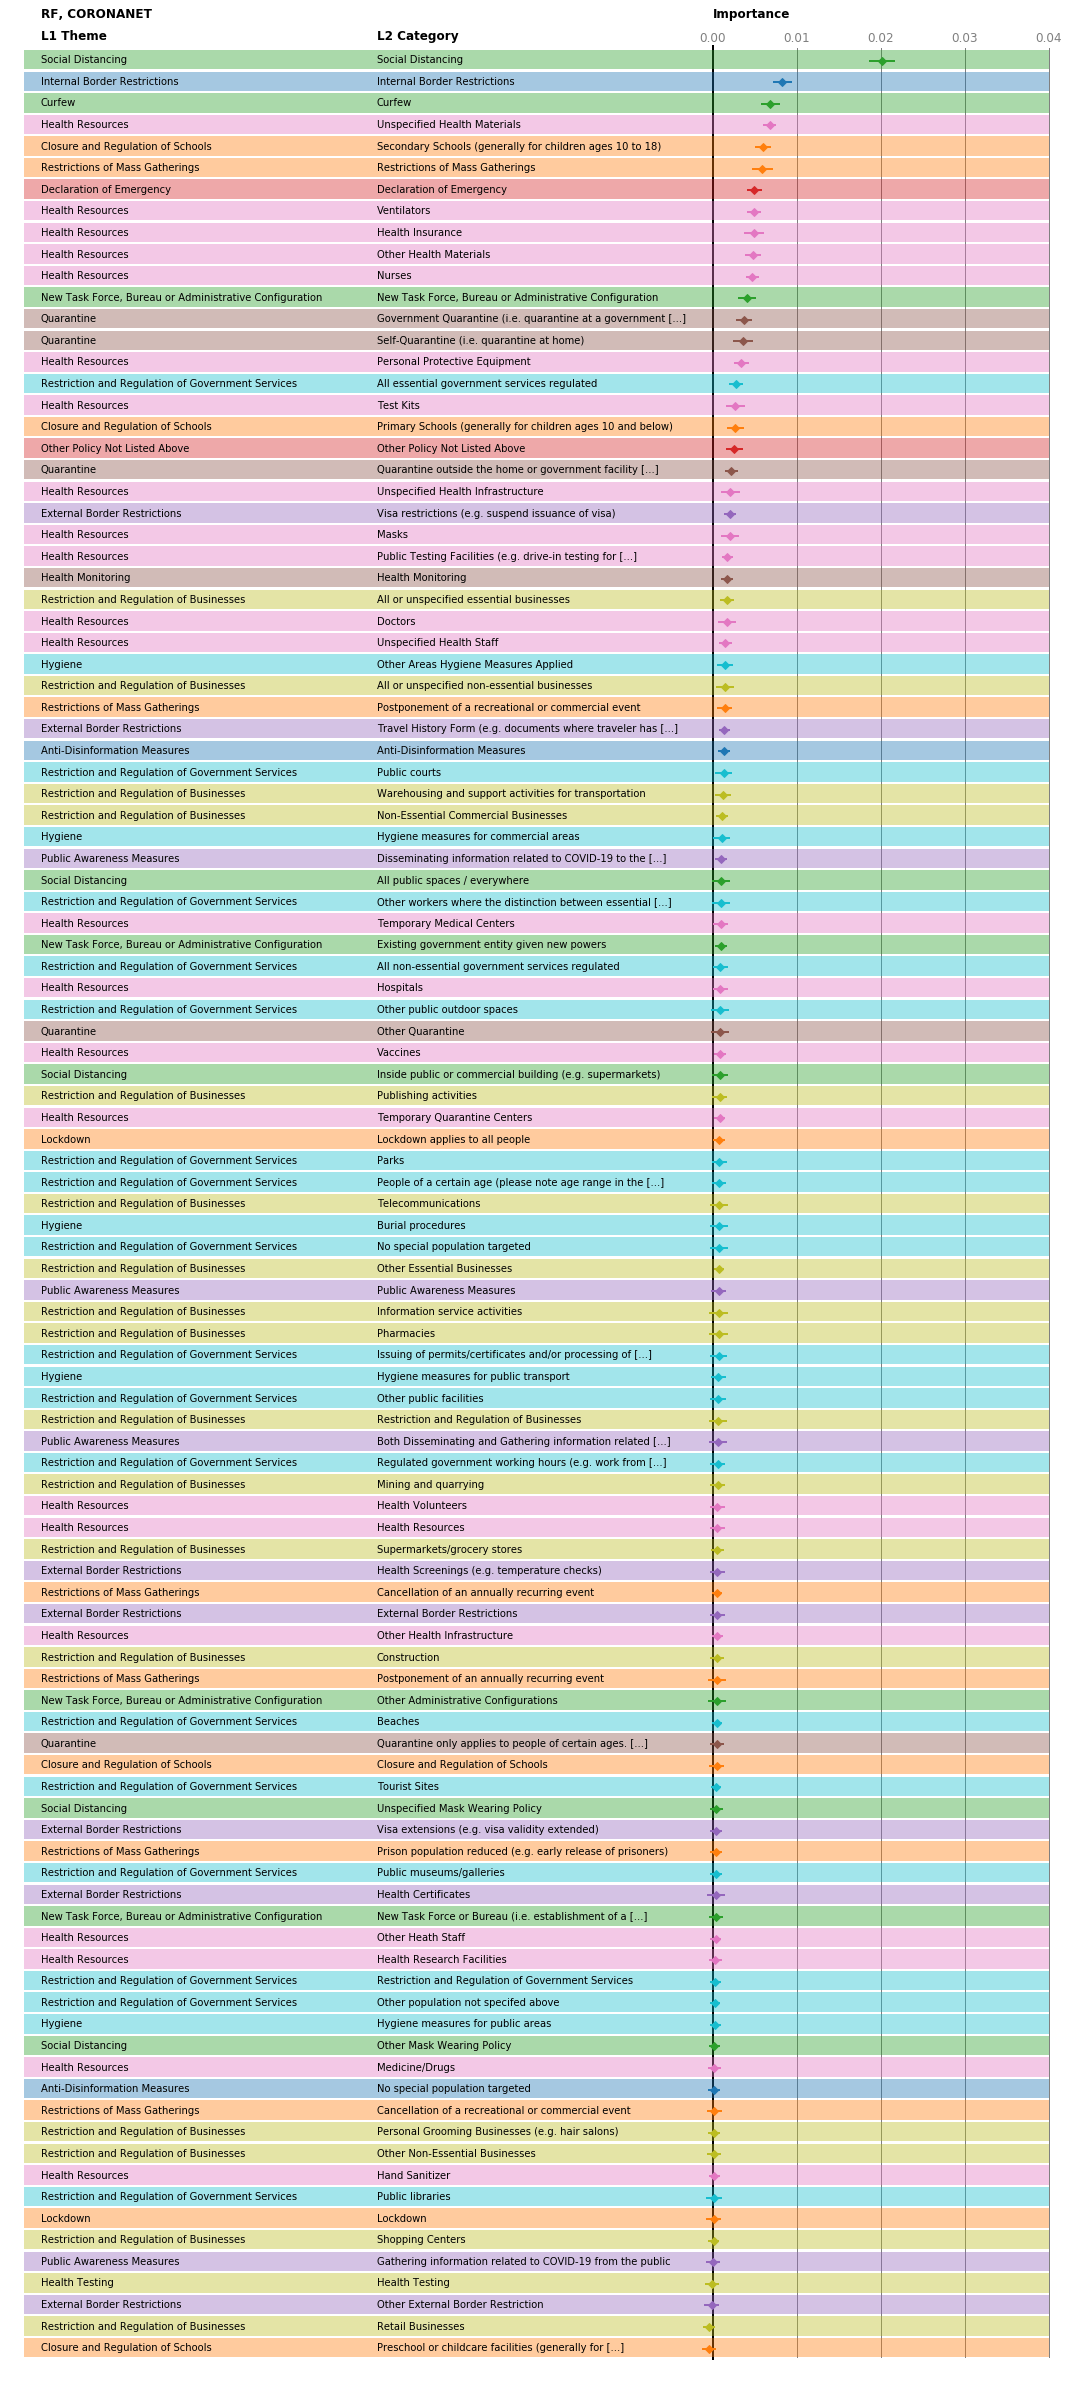

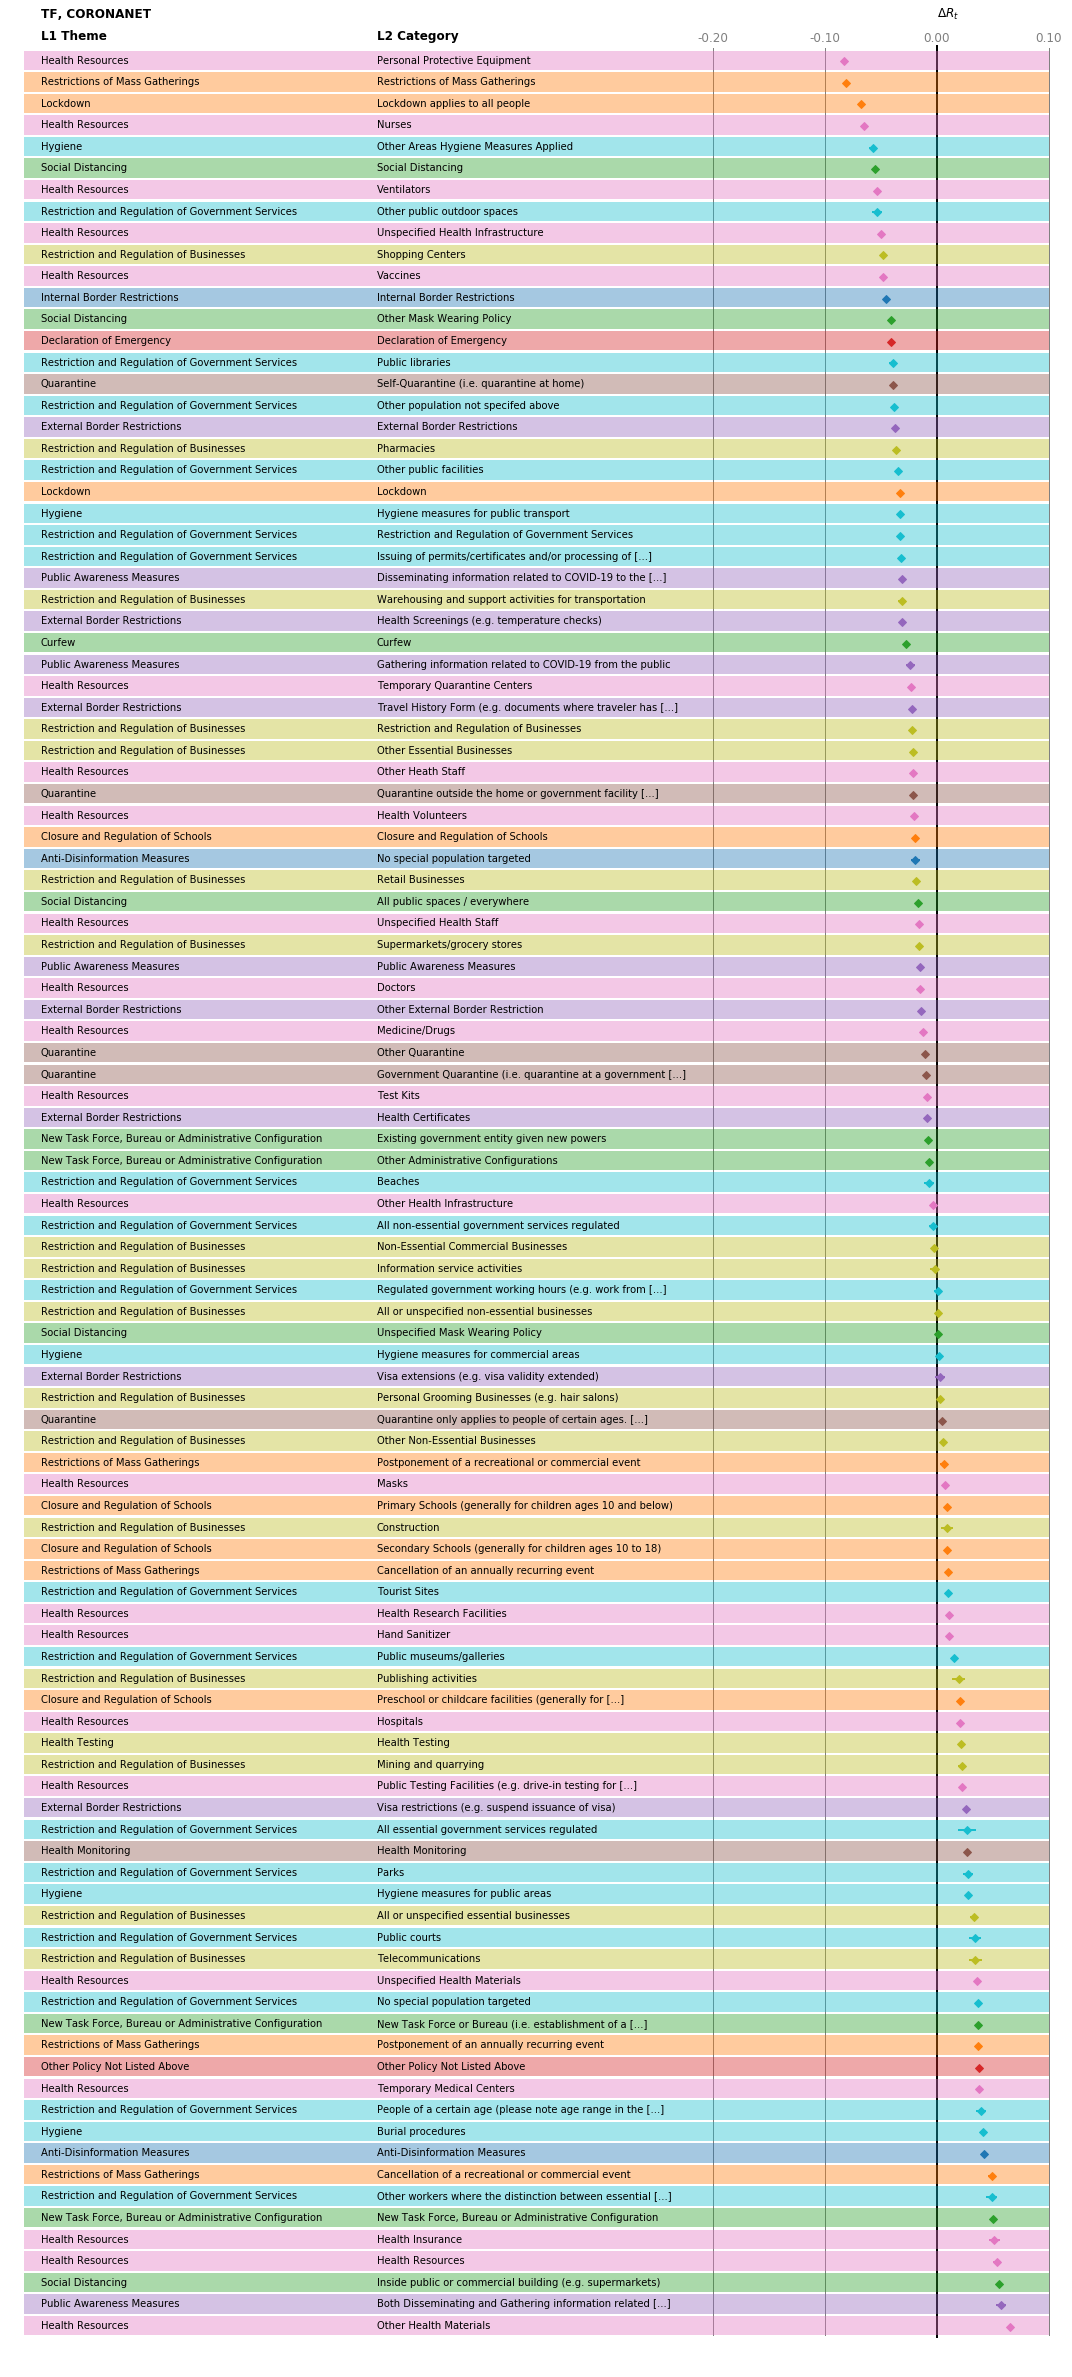

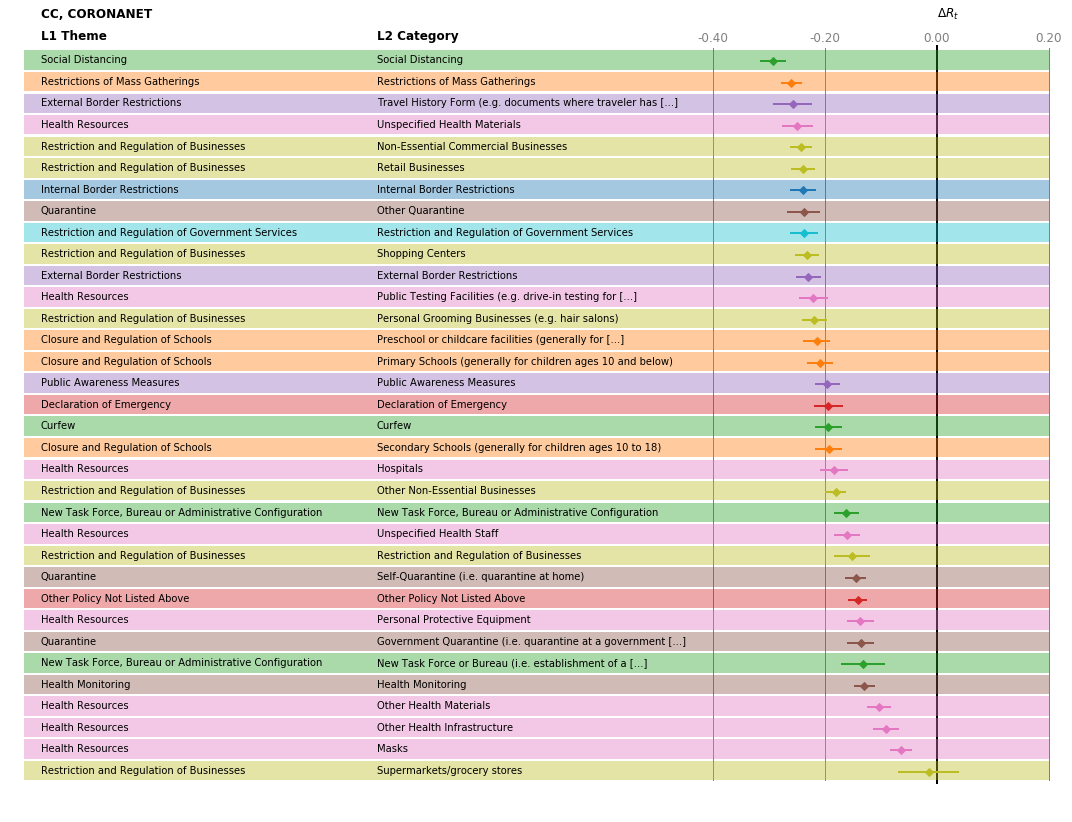

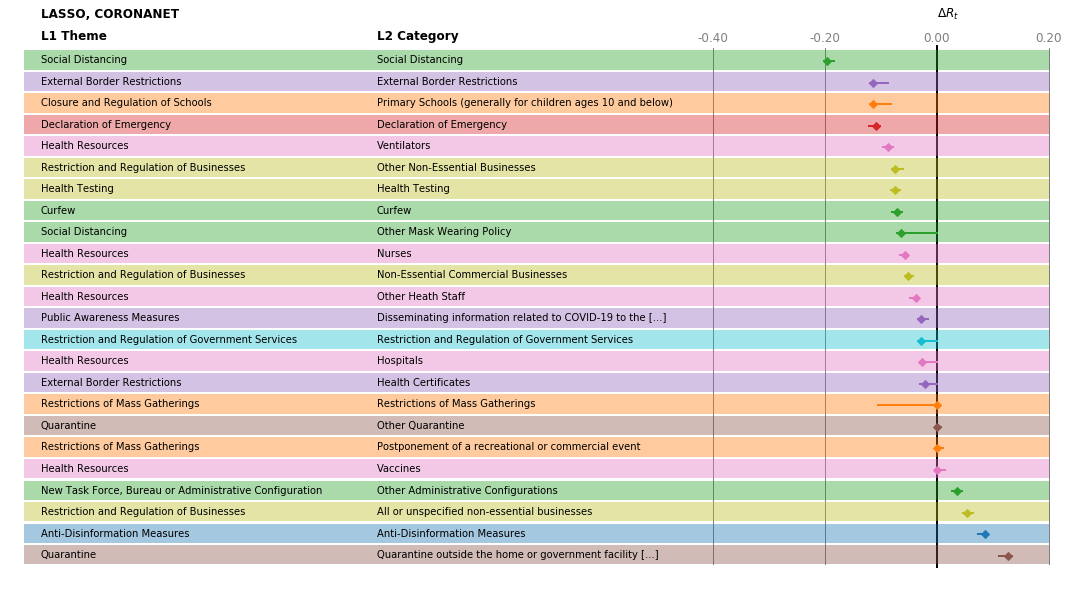

In [36]:
L1colors = crossval_cn.L1colors

drop_zeros = True
measure_effects = {}
sort_order = {'RF':False,'CC':True,'TF':True,'LASSO':True,'SCORE':False}
textbreak = 60
plot_keys = {}
for method in sort_order.keys():
    plot_keys[method] = ['{}_DeltaR'.format(method),'{}_low'.format(method),'{}_high'.format(method)]

PlotMeasureListSorted(measure_effects = mainresults_cn, plot_keys = plot_keys['SCORE'], sort_ascending = sort_order['SCORE'], entryheight=.3, title = 'Score, CORONANET', filename = 'measurelist_200906_CORONANET_SCORES.pdf', textbreak = textbreak, graylines = [20,40,60,80], blacklines = [0,100], labelsize = 100, border = 5, observable = 'Normalized Score')
PlotMeasureListSorted(measure_effects = mainresults_cn, plot_keys = plot_keys['RF'],    sort_ascending = sort_order['RF'],    entryheight=.3, title = 'RF, CORONANET',    filename = 'measurelist_200906_CORONANET_RF.pdf',     textbreak = textbreak, graylines = [1,2,3,4],    labelsize = 4,  border = .2, observable = 'Importance')
PlotMeasureListSorted(measure_effects = mainresults_cn, plot_keys = plot_keys['TF'],    sort_ascending = sort_order['TF'],    entryheight=.3, title = 'TF, CORONANET',    filename = 'measurelist_200906_CORONANET_TF.pdf',     textbreak = textbreak, graylines = [-10,-20,10], labelsize = 30, border = 1.5)
PlotMeasureListSorted(measure_effects = mainresults_cn, plot_keys = plot_keys['CC'],    sort_ascending = sort_order['CC'],    entryheight=.3, title = 'CC, CORONANET',    filename = 'measurelist_200906_CORONANET_CC.pdf',     textbreak = textbreak, graylines = [-40,-20,20], labelsize = 60, border = 3)
PlotMeasureListSorted(measure_effects = mainresults_cn, plot_keys = plot_keys['LASSO'], sort_ascending = sort_order['LASSO'], entryheight=.3, title = 'LASSO, CORONANET', filename = 'measurelist_200906_CORONANET_LASSO.pdf',  textbreak = textbreak, graylines = [-40,-20,20], labelsize = 60, border = 3)



In [38]:
# WHOPHSM

mainresults_who = pd.read_csv('data/comparison_of_rankings_revision - Main_results_WHOPHSM.csv')

score_results_who = pd.read_csv('data/comparison_of_rankings_revision - L2 Scores_WHOPHSM.csv', header = 0)

mainresults_who = mainresults_who.merge(score_results_who,left_on = ['Indexname'], right_on = ['Indexname'])

mainresults_who.fillna(0, inplace = True)

mainresults_who.head()

Indexname  \
0          CleaningAndDisinfectingSurfacesAndObjects   
1                    ClosingInternationalLandBorders   
2  CommunicationsAndEngagementGeneralPublicAwaren...   
3     CommunicationsAndEngagementOtherCommunications   
4      DetectingAndIsolatingCasesActiveCaseDetection   

                             L1 theme  \
0              Environmental measures   
1       International travel measures   
2                      Other measures   
3                      Other measures   
4  Surveillance and response measures   

                                         L2 category  \
0     Cleaning and disinfecting surfaces and objects   
1                 Closing international land borders   
2  Communications and engagement -- General publi...   
3  Communications and engagement -- Other communi...   
4  Detecting and isolating cases -- Active case d...   

   Territories with Implementation  Delta_RF  95%CI_Delta_RF  Delta_CC  \
0                               57  0.001273        0.000634  -0.12963   
1                              211  0.002970        0.000706  -0.22389   
2                              238  0.000864        0.000623  -0.16662   
3                              113  0.000853        0.000604  -0.13891   
4                               86  0.003266        0.000839   0.00000   

   95%CI_Delta_CC  Rank_RNN  Delta_RNN  ...  LASSO_mean  LASSO_std        CC  \
0        0.036599        37   0.007014  ...    0.000000   0.000000  0.182440   
1        0.020596        17  -0.008369  ...   -0.153207   0.013088  0.560200   
2        0.014893        31   0.001489  ...    0.001089   0.005373  0.576498   
3        0.024650        35   0.005796  ...    0.000000   0.000000  0.290221   
4        0.000000        22  -0.003378  ...   -0.000090   0.001254  0.000000   

      LASSO        RF  Transformer      Mean  Prevalence All Countries  \
0  0.000000  0.125199     0.000000  0.076910                  0.103135   
1  0.627546  0.262154     0.000000  0.362475                  0.354981   
2  0.000000  0.086432     0.193732  0.214165                  0.077734   
3  0.000000  0.088020     0.000000  0.094560                  0.114484   
4  0.000000  0.242453     0.000000  0.060613                  0.170510   

   Prevalence Implementing Countries  Fraction of Implementating Countries  
0                           0.561000                              0.161458  
1                           0.840299                              0.359375  
2                           0.785259                              0.093750  
3                           0.609008                              0.156250  
4                           0.536109                              0.307292  

[5 rows x 27 columns]

In [39]:
mainresults_who['CC_low']   = mainresults_who['Delta_CC']  - mainresults_who['95%CI_Delta_CC']
mainresults_who['RF_low']   = mainresults_who['Delta_RF']  - mainresults_who['95%CI_Delta_RF']
mainresults_who['TF_low']   = mainresults_who['Delta_Transformer'] - mainresults_who['95%CI_Delta_Transformer']

mainresults_who['CC_high']  = mainresults_who['Delta_CC']  + mainresults_who['95%CI_Delta_CC']
mainresults_who['RF_high']  = mainresults_who['Delta_RF']  + mainresults_who['95%CI_Delta_RF']
mainresults_who['TF_high']  = mainresults_who['Delta_Transformer'] + mainresults_who['95%CI_Delta_Transformer']

mainresults_who['SCORE_low']  = mainresults_who['Mean']
mainresults_who['SCORE_high'] = mainresults_who['Mean']

mainresults_who.rename({'LASSO_median':'LASSO_DeltaR','LASSO_low95':'LASSO_low','LASSO_high95':'LASSO_high','Delta_CC':'CC_DeltaR','Delta_RF':'RF_DeltaR','Delta_Transformer':'TF_DeltaR','Mean':'SCORE_DeltaR'}, axis = 'columns', inplace = True)
mainresults_who.head()

Indexname  \
0          CleaningAndDisinfectingSurfacesAndObjects   
1                    ClosingInternationalLandBorders   
2  CommunicationsAndEngagementGeneralPublicAwaren...   
3     CommunicationsAndEngagementOtherCommunications   
4      DetectingAndIsolatingCasesActiveCaseDetection   

                             L1 theme  \
0              Environmental measures   
1       International travel measures   
2                      Other measures   
3                      Other measures   
4  Surveillance and response measures   

                                         L2 category  \
0     Cleaning and disinfecting surfaces and objects   
1                 Closing international land borders   
2  Communications and engagement -- General publi...   
3  Communications and engagement -- Other communi...   
4  Detecting and isolating cases -- Active case d...   

   Territories with Implementation  RF_DeltaR  95%CI_Delta_RF  CC_DeltaR  \
0                               57   0.001273        0.000634   -0.12963   
1                              211   0.002970        0.000706   -0.22389   
2                              238   0.000864        0.000623   -0.16662   
3                              113   0.000853        0.000604   -0.13891   
4                               86   0.003266        0.000839    0.00000   

   95%CI_Delta_CC  Rank_RNN  Delta_RNN  ...  \
0        0.036599        37   0.007014  ...   
1        0.020596        17  -0.008369  ...   
2        0.014893        31   0.001489  ...   
3        0.024650        35   0.005796  ...   
4        0.000000        22  -0.003378  ...   

   Prevalence Implementing Countries  Fraction of Implementating Countries  \
0                           0.561000                              0.161458   
1                           0.840299                              0.359375   
2                           0.785259                              0.093750   
3                           0.609008                              0.156250   
4                           0.536109                              0.307292   

     CC_low    RF_low    TF_low   CC_high   RF_high   TF_high  SCORE_low  \
0 -0.166229  0.000639  0.025890 -0.093031  0.001907  0.027539   0.076910   
1 -0.244486  0.002264  0.002623 -0.203294  0.003676  0.003540   0.362475   
2 -0.181513  0.000241 -0.021101 -0.151727  0.001487 -0.019702   0.214165   
3 -0.163560  0.000249  0.029620 -0.114260  0.001457  0.031330   0.094560   
4  0.000000  0.002427  0.002552  0.000000  0.004105  0.003911   0.060613   

   SCORE_high  
0    0.076910  
1    0.362475  
2    0.214165  
3    0.094560  
4    0.060613  

[5 rows x 35 columns]

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


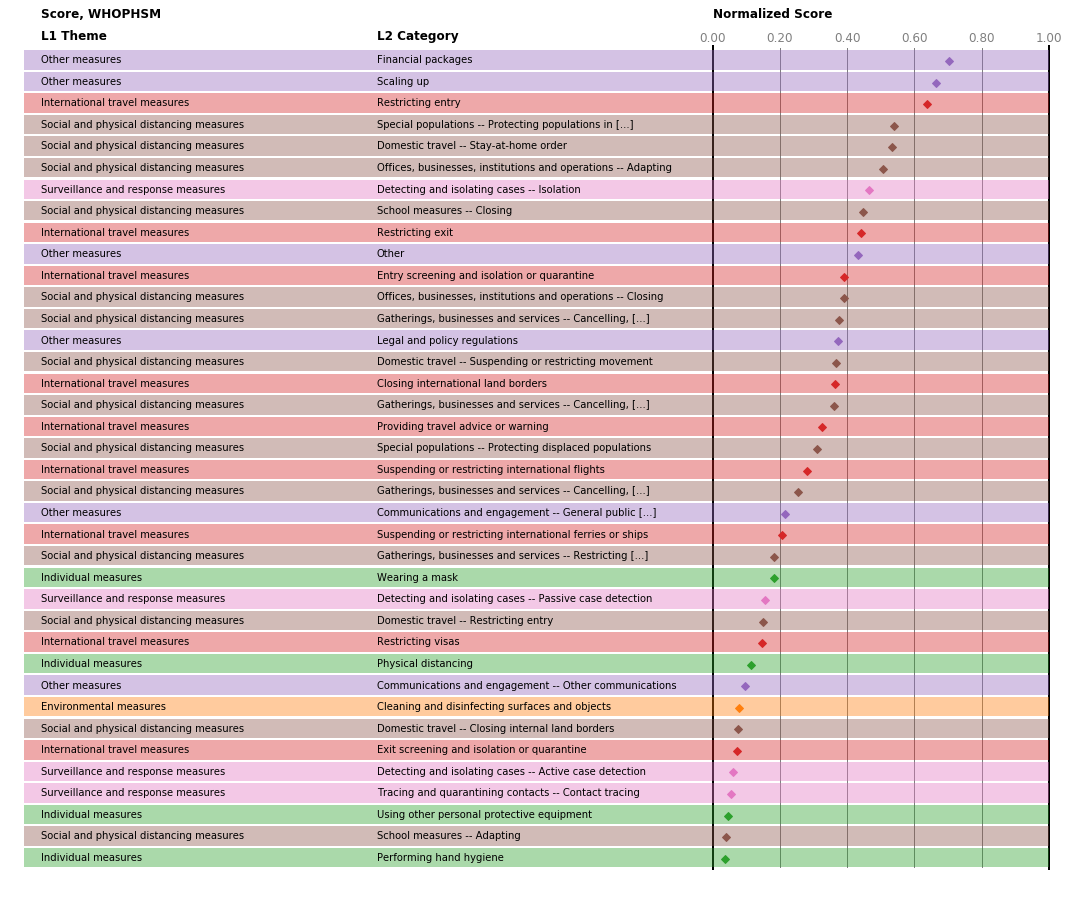

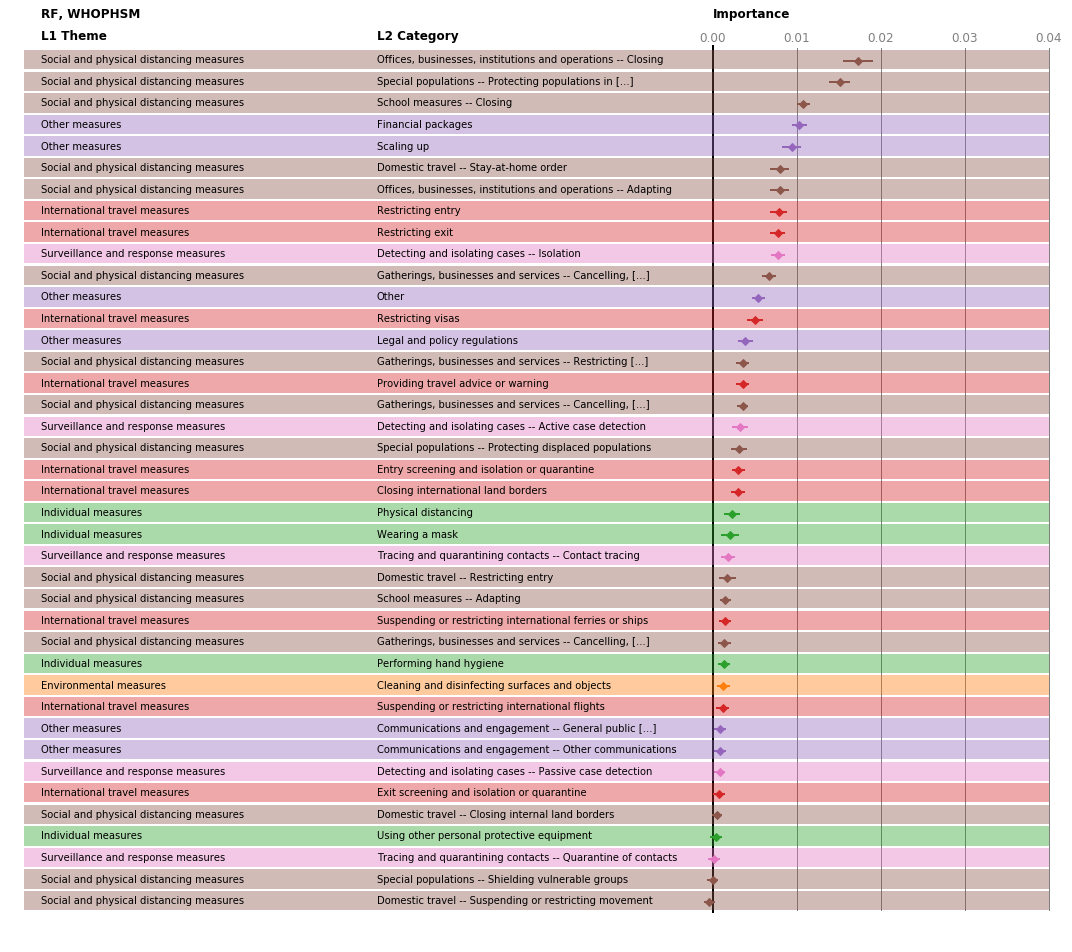

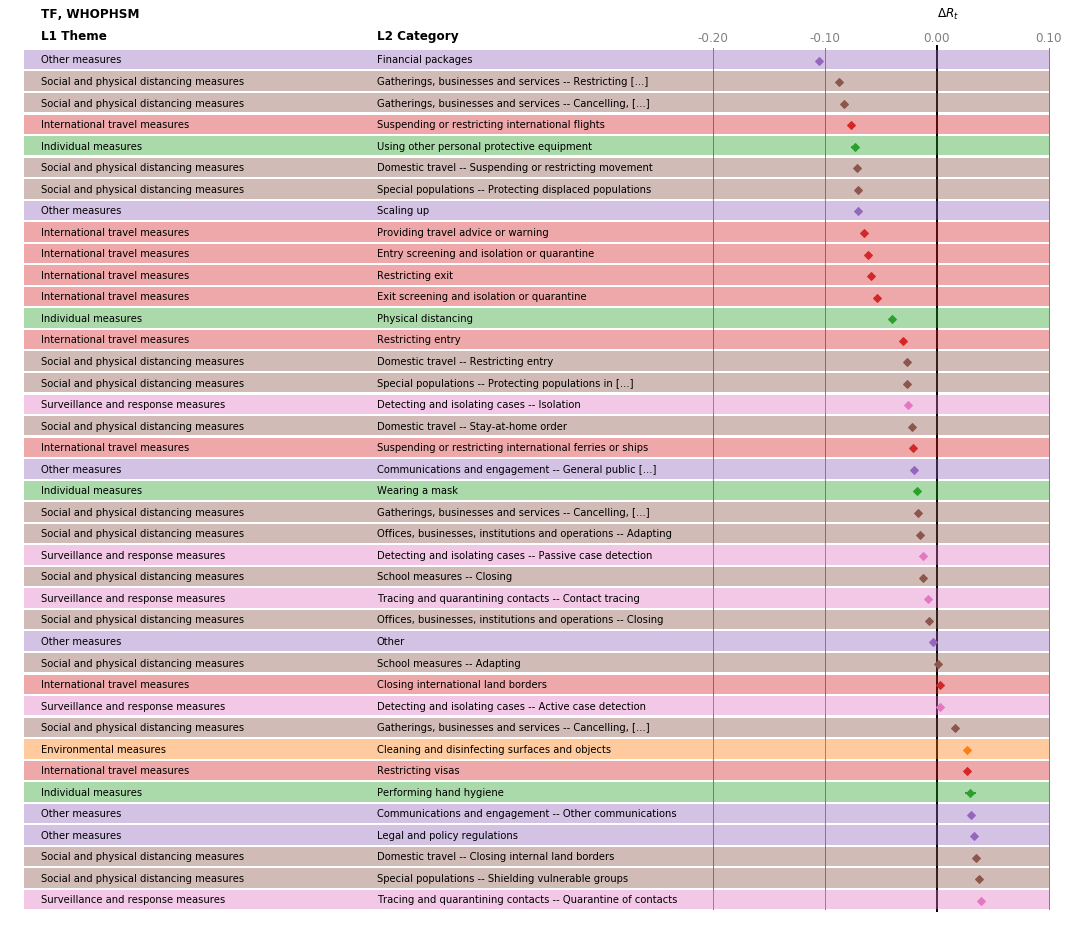

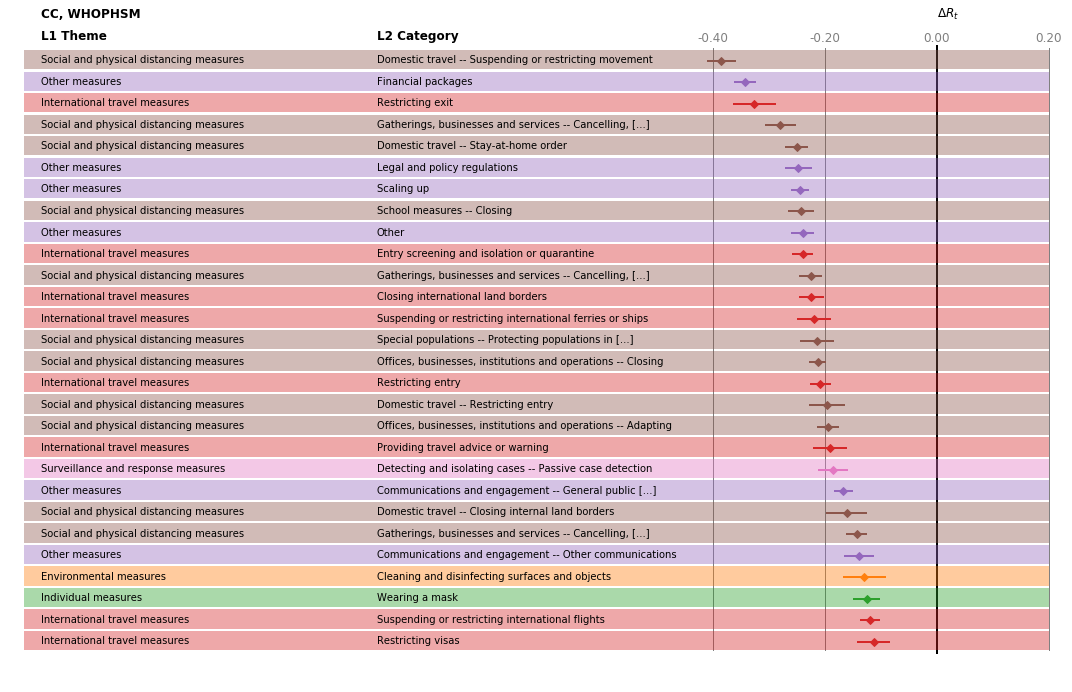

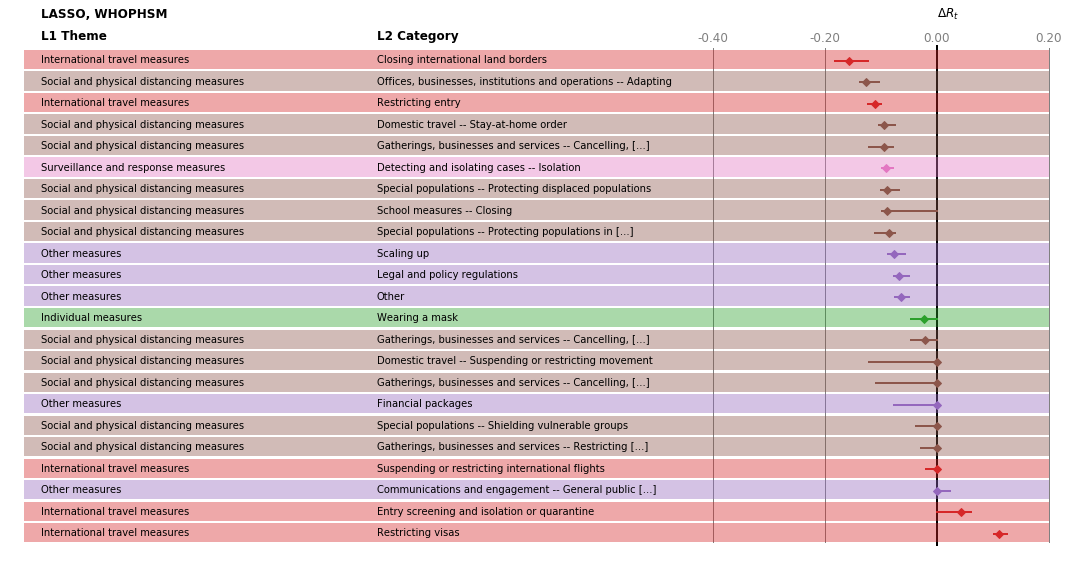

In [40]:
L1colors = crossval_who.L1colors

drop_zeros = True
measure_effects = {}
sort_order = {'RF':False,'CC':True,'TF':True,'LASSO':True,'SCORE':False}
textbreak = 60
plot_keys = {}
for method in sort_order.keys():
    plot_keys[method] = ['{}_DeltaR'.format(method),'{}_low'.format(method),'{}_high'.format(method)]

PlotMeasureListSorted(measure_effects = mainresults_who, plot_keys = plot_keys['SCORE'], sort_ascending = sort_order['SCORE'], entryheight=.3, title = 'Score, WHOPHSM', filename = 'measurelist_200906_WHOPHSM_SCORES.pdf', textbreak = textbreak, graylines = [20,40,60,80], blacklines = [0,100], labelsize = 100, border = 5, observable = 'Normalized Score')
PlotMeasureListSorted(measure_effects = mainresults_who, plot_keys = plot_keys['RF'],    sort_ascending = sort_order['RF'],    entryheight=.3, title = 'RF, WHOPHSM',    filename = 'measurelist_200906_WHOPHSM_RF.pdf',     textbreak = textbreak, graylines = [1,2,3,4],    labelsize = 4,  border = .2, observable = 'Importance')
PlotMeasureListSorted(measure_effects = mainresults_who, plot_keys = plot_keys['TF'],    sort_ascending = sort_order['TF'],    entryheight=.3, title = 'TF, WHOPHSM',    filename = 'measurelist_200906_WHOPHSM_TF.pdf',     textbreak = textbreak, graylines = [-10,-20,10], labelsize = 30, border = 1.5)
PlotMeasureListSorted(measure_effects = mainresults_who, plot_keys = plot_keys['CC'],    sort_ascending = sort_order['CC'],    entryheight=.3, title = 'CC, WHOPHSM',    filename = 'measurelist_200906_WHOPHSM_CC.pdf',     textbreak = textbreak, graylines = [-40,-20,20], labelsize = 60, border = 3)
PlotMeasureListSorted(measure_effects = mainresults_who, plot_keys = plot_keys['LASSO'], sort_ascending = sort_order['LASSO'], entryheight=.3, title = 'LASSO, WHOPHSM', filename = 'measurelist_200906_WHOPHSM_LASSO.pdf',  textbreak = textbreak, graylines = [-40,-20,20], labelsize = 60, border = 3)



In [ ]:
boxalpha = .4
plot_lines = {'CC':{'gray':[-.40,-.20,.20],'black':[0]},'LASSO' : {'gray':[-.40,-.20,.20],'black':[0]},'RF':{'gray':[.01,.02,.03,.04],'black':[0]},'RNN':{'gray':[-.4,-.20,.20],'black':[0]}}


def SignificantMeasure(values,method):
    if values[method] > 0: return True
    return False


def ShowLines(ax, gray = [], black = [], xmin = 0, ymin = 0, ymax = 0, xscale = 1, xoffset = 0, ytext = 2):
    for x in black:
        ax.plot([xscale * x + xoffset - xmin,xscale * x + xoffset - xmin],[ymin,ymax], lw = 2, c = 'black',zorder = -2)
        ax.annotate('{:.2f}'.format(x),[xscale * x + xoffset - xmin, ytext],fontsize = 12, c = 'gray', ha = 'center', va = 'top', rotation = 90)
    for x in gray:
        ax.plot([xscale * x + xoffset - xmin, xscale * x + xoffset - xmin],[ymin, ymax], lw = 1, c = 'gray',zorder = -2)
        ax.annotate('{:.2f}'.format(x),[xscale*x + xoffset - xmin, ytext],fontsize = 12, c = 'gray', ha = 'center', va = 'top', rotation = 90)

        
def PlotData(ax, xscale = 1, xoffset = 0, yoffset = 0, minplot = 0, data_keys = ['median','low','high'], ypos = 1, values = None, textbreak = 40, background = True):
    if background:
        ax.plot(xscale * values[data_keys[0]] - minplot + xoffset,[ypos + yoffset], c = L1colors[values['L1 theme']], marker = 'D', zorder = 10)
        ax.plot([xscale * values[data_keys[1]] - minplot + xoffset,xscale * values[data_keys[2]] - minplot + xoffset],[ypos + yoffset,ypos + yoffset], c = L1colors[values['L1 theme']], lw = 2, zorder = 10)
        bgcolor = L1colors[values['L1 theme']]
    else:
        bgcolor = '#d3d7cf'
        
    background_data = plt.Rectangle([xoffset, ypos - .4], 1, .9, fill = True, fc = bgcolor, alpha = boxalpha, zorder = 10)
    ax.add_patch(background_data)

        
def PlotMeasureListCombined(measure_effects, plot_keys = {}, filename = 'measurelist_sorted.pdf', figsize = (15,32), labelsize = 150, blacklines = [0], graylines = [-40,-20,20],
                          border = .15, title = '', textbreak = 50, include_countries = False, rescale = True, entryheight = None):

    fig,ax = plt.subplots(figsize = figsize)
    plot_height = len(measure_effects)
    
    allmethods = list(plot_keys.keys())
    allmethods.sort()
    
    for j,(index,values) in enumerate(measure_effects.iterrows()):
        background_text = plt.Rectangle([-3 - border, -j - .4], 3, .9, fill = True, fc = L1colors[values['L1 theme']], alpha = boxalpha, zorder = 1)
        ax.annotate(textwrap.shorten(str(values['L2 category']), width = textbreak), [-3, -j - .1], ha = 'left', zorder = 20)
        ax.add_patch(background_text)
        
        for m,method in enumerate(allmethods):
            all_lines = np.concatenate([plot_lines[method]['gray'], plot_lines[method]['black']])
            xscale    = 1/(np.max(all_lines) - np.min(all_lines))
            minplot   = np.min(all_lines) * xscale
            xoffset   = m * (1 + border)
            
            show_background = SignificantMeasure(values,method)
            
            PlotData(ax, data_keys=plot_keys[method], ypos = -j,values = values, textbreak = textbreak, xscale = xscale, xoffset = xoffset, background = show_background, minplot = minplot)
            if j == 0:
                ax.annotate(method, [xoffset,2.8],weight = 'bold',fontsize = 12)
                ShowLines(ax, gray = plot_lines[method]['gray'], black = plot_lines[method]['black'], xscale = xscale, xoffset = xoffset, ymin = -plot_height + .5, ymax = .6, xmin = minplot)

    legend_width = (7 + 4*border)/2 - border
    if 'Country Effects' in L1colors:
        del L1colors['Country Effects']
    ax.annotate('L1 Themes',[-border-3,-plot_height-2],weight = 'bold')
    for i,(l1category, color) in enumerate(L1colors.items()):
        l1back = plt.Rectangle([-3-border + (i%2) * (legend_width + border),-plot_height - (i//2) -3-.4],legend_width,.9,fill=True,fc=color,alpha = boxalpha, zorder= 1)
        ax.add_patch(l1back)
        ax.annotate(l1category,[-3+ (i%2) * (legend_width + border) ,-plot_height - (i//2) -3], color = color, weight = 'bold', zorder = 10, fontsize = 10)
    
    ax.set_ylim([-plot_height - len(L1colors) - 3,3])
    ax.axis('off')
    fig.savefig(filename, bbox_inches='tight')



In [ ]:
if 'SCORE' in plot_keys.keys():
    del plot_keys['SCORE']
mainresults_sortscore = mainresults.sort_values(by = 'SCORE_DeltaR', ascending = False)
PlotMeasureListCombined(mainresults_sortscore, plot_keys, filename='measurelist_final_combined.pdf')